# Higgs boson data analysis with Deep Learning

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Loading and preparation

In [37]:
import pandas as pd

data = pd.read_csv("gdrive/My Drive/HiggsBoson_Astrostatistic/higgs.csv")

There are lots of data with value $-999$, which means that the data is missing. We replace these values with $0$, and we add a new binary column to the dataset, which indicates whether the data was missing or not.

In [38]:
y = data['Label']
# Create binary columns for -999 values before dropping columns
for col in data.columns:
    if (data[col] == -999.0).any():
        data[f'{col}_missing'] = (data[col] == -999.0).astype(int)

data_processed = data.drop(['Label', 'Weight', 'EventId'], axis=1)

cols = data_processed.columns.tolist()
new_cols = []
missing_cols = [col for col in cols if '_missing' in col]
original_cols = [col for col in cols if '_missing' not in col]

for col in original_cols:
    new_cols.append(col)
    if f'{col}_missing' in missing_cols:
        new_cols.append(f'{col}_missing')

X = data_processed[new_cols]

# Replace -999.0 with 0
X = X.replace(-999.0, 0)

X

,DER_mass_MMC,DER_mass_MMC_missing,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_deltaeta_jet_jet_missing,DER_mass_jet_jet,DER_mass_jet_jet_missing,DER_prodeta_jet_jet,...,PRI_jet_leading_eta_missing,PRI_jet_leading_phi,PRI_jet_leading_phi_missing,PRI_jet_subleading_pt,PRI_jet_subleading_pt_missing,PRI_jet_subleading_eta,PRI_jet_subleading_eta_missing,PRI_jet_subleading_phi,PRI_jet_subleading_phi_missing,PRI_jet_all_pt
0,138.470,0,51.655,97.827,27.980,0.91,0,124.711,0,2.666,...,0,0.444,0,46.062,0,1.24,0,-2.475,0,113.497
1,160.937,0,68.768,103.235,48.146,0.00,1,0.000,1,0.000,...,0,1.158,0,0.000,1,0.00,1,0.000,1,46.226
2,0.000,1,162.172,125.953,35.635,0.00,1,0.000,1,0.000,...,0,-2.028,0,0.000,1,0.00,1,0.000,1,44.251
3,143.905,0,81.417,80.943,0.414,0.00,1,0.000,1,0.000,...,1,0.000,1,0.000,1,0.00,1,0.000,1,-0.000
4,175.864,0,16.915,134.805,16.405,0.00,1,0.000,1,0.000,...,1,0.000,1,0.000,1,0.00,1,0.000,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.000,1,71.989,36.548,5.042,0.00,1,0.000,1,0.000,...,1,0.000,1,0.000,1,0.00,1,0.000,1,0.000
249996,0.000,1,58.179,68.083,22.439,0.00,1,0.000,1,0.000,...,1,0.000,1,0.000,1,0.00,1,0.000,1,-0.000
249997,105.457,0,60.526,75.839,39.757,0.00,1,0.000,1,0.000,...,0,-0.166,0,0.000,1,0.00,1,0.000,1,41.992
249998,94.951,0,19.362,68.812,13.504,0.00,1,0.000,1,0.000,...,1,0.000,1,0.000,1,0.00,1,0.000,1,0.000


### Standard scaler
$$
z_i = \frac{x_i - \bar{x}}{\delta x}
$$

where $\bar{x}$ is the mean and $\delta x$ is the Standard Deviation of the dataset

In [39]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def scaler(data):
    data_scaled = pd.DataFrame()
    for col in data.columns:
        scaler = StandardScaler()
        data_scaled[col] = scaler.fit_transform(data[[col]])[:,0]
    return data_scaled

X_scaled = scaler(X)

### Train, Test and Validation division


In [40]:
from sklearn.model_selection import train_test_split
import numpy as np

y_array = np.array(y)
# Convert 's' and 'b' to 1 and 0
y_array = np.where(y_array == 's', 1, 0)

X_array = np.array([row for row in X_scaled.values])

test_size=0.1
val_size=0.2

X_train_val, X_test, y_train_val, y_test = train_test_split(X_array, y_array, test_size=test_size, random_state=42)

val_relative_size = val_size / (1 - test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_relative_size, random_state=42)

print(f"Train shape (X): {X_train.shape}")
print(f"Validation shape (X): {X_val.shape}")
print(f"Test shape (X): {X_test.shape}")
print(f"Train shape (y): {y_train.shape}")
print(f"Validation shape (y): {y_val.shape}")
print(f"Test shape (y): {y_test.shape}")

Train shape (X): (175000, 41)
Validation shape (X): (50000, 41)
Test shape (X): (25000, 41)
Train shape (y): (175000,)
Validation shape (y): (50000,)
Test shape (y): (25000,)


## Some useful functions

### Callback and Learning Rate regularization

In [41]:
import tensorflow as tf
import numpy as np

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

### Function to visualize the results

In [42]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np

def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    auc = history.history['auc']
    val_auc = history.history['val_auc']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(loss, label='Training Loss')
    axes[0].plot(val_loss, label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    axes[2].plot(auc, label='Training AUC')
    axes[2].plot(val_auc, label='Validation AUC')
    axes[2].set_title('AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


def visualize_loss_pdf(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(loss, bins=100, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution: Training Loss')
    axes[0].set_xlabel('Loss')
    axes[0].set_ylabel('Count')

    axes[1].hist(val_loss, bins=100, color='salmon', edgecolor='black')
    axes[1].set_title('Distribution: Validation Loss')
    axes[1].set_xlabel('Loss')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


def ROC_curves(y_true, y_recs, labels):
    plt.figure(figsize=(8, 6))
    for y_rec, label in zip(y_recs, labels):
        fpr, tpr, _ = roc_curve(y_true, y_rec)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=label + '(AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()


def ConfusionMatrix(y_true, y_rec):
    N = len(y_true)
    y_pred_binary = (y_rec > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    cm_normalized = cm.astype('float') / N
    cm_4comparison = confusion_matrix(y_true, y_true)
    cm_4comparison_normalized = cm_4comparison.astype('float') / N

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
    axes[0].set_title('True vs Predict')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_4comparison_normalized, annot=True, fmt=".2f", cmap="Oranges", ax=axes[1])
    axes[1].set_title('True vs True')
    axes[1].set_xlabel('True')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

##  Feed Forward Network (FFN)

The first idea is to use a Feed Forward Network (FFN), this is the simplest type of neural network, where the information flows in one direction, from the input layer to the output layer, through the differents hidden layers.

In [43]:
import keras
import tensorflow as tf

# --- Hyperparameters ---
dropout_rate = 0.5
regularizer_rate = 1e-5

# --- Inputs ---
inputs = keras.layers.Input(shape=(41,))

x = inputs
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# --- Model ---
ffn = keras.Model(inputs, outputs)
ffn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,377 (83.50 KB)

 Trainable params: 21,377 (83.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

For the training we use the **Adam optimizer** with a beginning learning rate of $0.001$ and the **binary crossentropy loss**.


In [44]:
# Compile
ffn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
 )

# Training
history_ffn = ffn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=512,
    shuffle=True,
    callbacks=[reduce_lr, early_stopping]
)

ffn.save_weights("gdrive/My Drive/HiggsBoson_Astrostatistic/weights/FFN.weights.h5")

Epoch 1/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6387 - auc: 0.6334 - loss: 0.6768 - val_accuracy: 0.7555 - val_auc: 0.8181 - val_loss: 0.5102 - learning_rate: 5.0000e-04
Epoch 2/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7354 - auc: 0.7889 - loss: 0.5315 - val_accuracy: 0.7816 - val_auc: 0.8511 - val_loss: 0.4621 - learning_rate: 5.0000e-04
Epoch 3/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7638 - auc: 0.8243 - loss: 0.4955 - val_accuracy: 0.8040 - val_auc: 0.8713 - val_loss: 0.4366 - learning_rate: 5.0000e-04
Epoch 4/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7842 - auc: 0.8432 - loss: 0.4734 - val_accuracy: 0.8150 - val_auc: 0.8806 - val_loss: 0.4198 - learning_rate: 5.0000e-04
Epoch 5/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7979 - auc: 0.8564 - loss: 0.4530 - val_accuracy: 0.8205 - val_auc: 0.8861 - val_loss: 0.4074 - learning_rate: 5.0000e-04
Epoch 6/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 

### Results

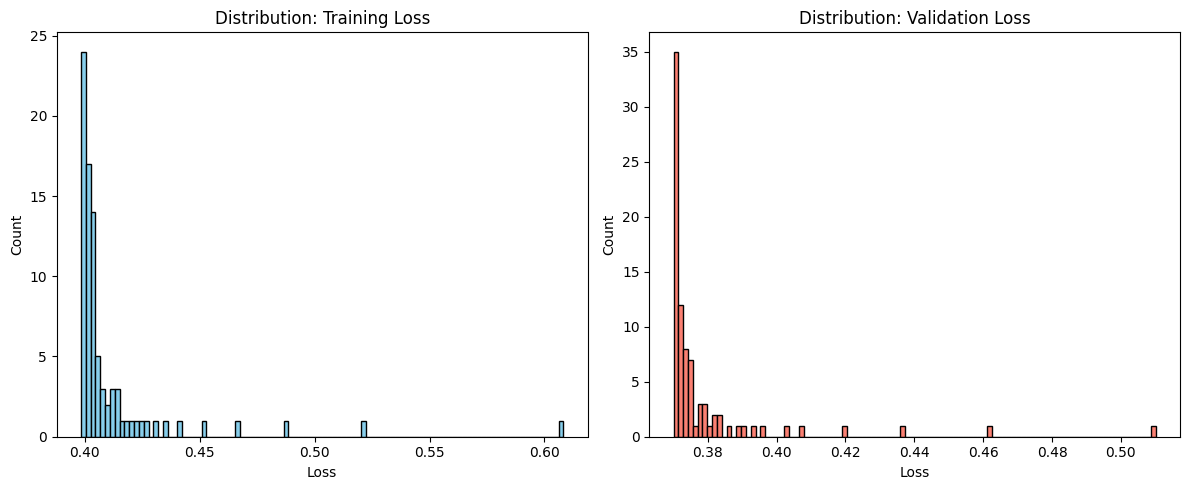

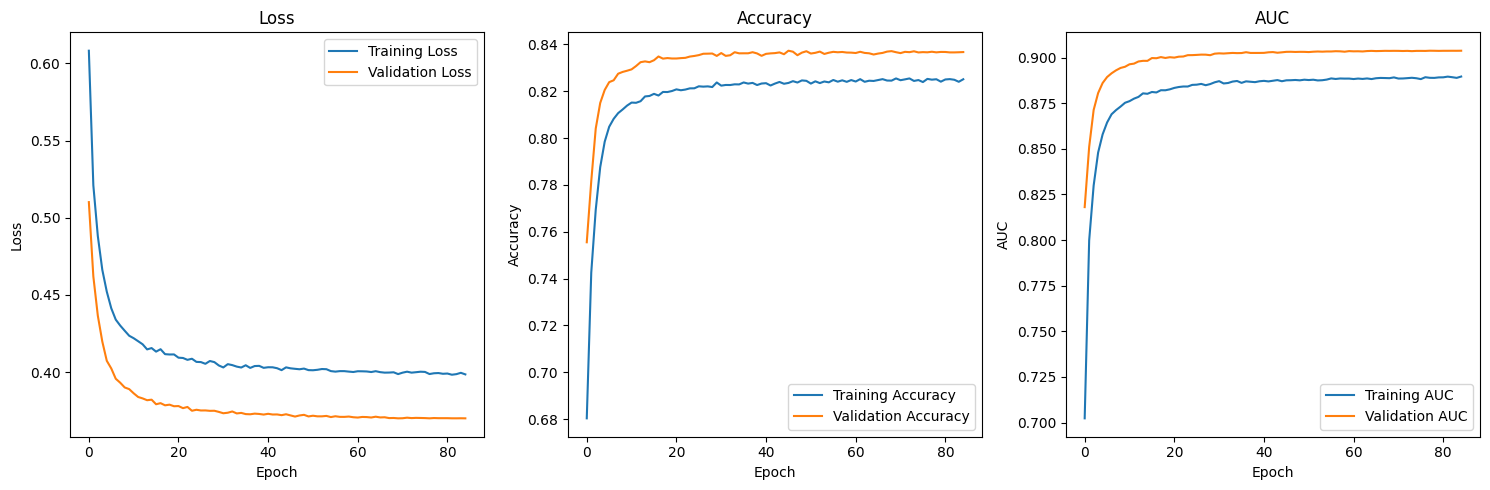

In [45]:
visualize_loss_pdf(history_ffn)
visualize_loss(history_ffn)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


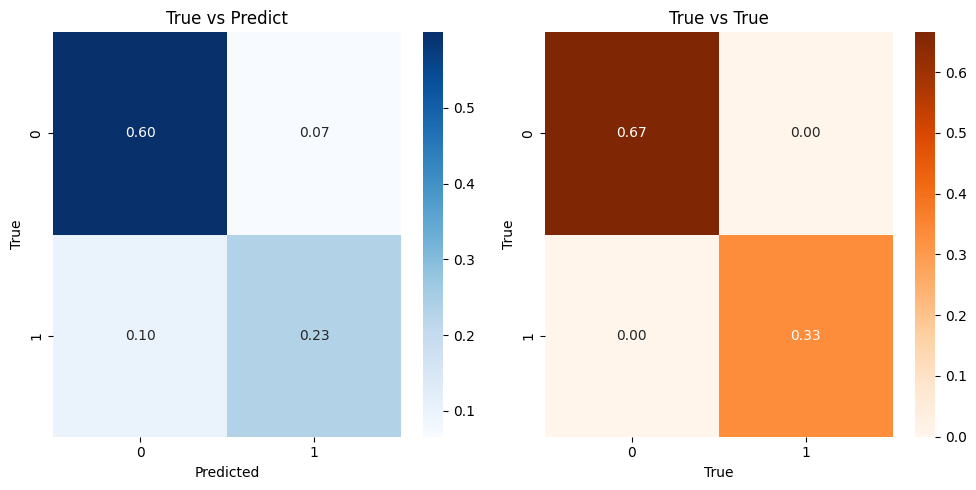

In [46]:
y_pred_ffn = ffn.predict(X_test)
ConfusionMatrix(y_test, y_pred_ffn)

## Convolutional Neural Network (CNN) 

To improve he performance we can think to use a 1D Convolutional Neural Network (CNN), for capture some local relationships between the features of the dataset.

In [47]:
import keras
import tensorflow as tf

# --- Hyperparameters ---
dropout_rate = 0.5

# --- Inputs ---
inputs = keras.layers.Input(shape=(41,))

x = keras.layers.Reshape((41, 1))(inputs)

x = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.GlobalAveragePooling1D()(x)

x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(dropout_rate)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# --- Model ---
cnn = keras.models.Model(inputs, outputs)
cnn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 41, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 41, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,481 (142.50 KB)

 Trainable params: 35,905 (140.25 KB)

 Non-trainable params: 576 (2.25 KB)

### Training the model

For the training we use the **Adam optimizer** with a beginning learning rate of $0.001$ and the **binary crossentropy loss**.


In [48]:
# Compile
cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
 )

# Training
history_cnn = cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=512,
    shuffle=True,
    callbacks=[reduce_lr, early_stopping]
)

cnn.save_weights("gdrive/My Drive/HiggsBoson_Astrostatistic/weights/CNN.weights.h5")

Epoch 1/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5755 - auc: 0.5334 - loss: 0.8112 - val_accuracy: 0.6619 - val_auc: 0.5409 - val_loss: 0.6521 - learning_rate: 5.0000e-04
Epoch 2/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6525 - auc: 0.5744 - loss: 0.6682 - val_accuracy: 0.6823 - val_auc: 0.7469 - val_loss: 0.5920 - learning_rate: 5.0000e-04
Epoch 3/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6752 - auc: 0.6559 - loss: 0.6208 - val_accuracy: 0.7404 - val_auc: 0.7896 - val_loss: 0.5609 - learning_rate: 5.0000e-04
Epoch 4/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6959 - auc: 0.7171 - loss: 0.5799 - val_accuracy: 0.7588 - val_auc: 0.8102 - val_loss: 0.5202 - learning_rate: 5.0000e-04
Epoch 5/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7121 - auc: 0.7472 - loss: 0.5574 - val_accuracy: 0.7628 - val_auc: 0.8196 - val_loss: 0.5004 - learning_rate: 5.0000e-04
Epoch 6/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step 

### Results

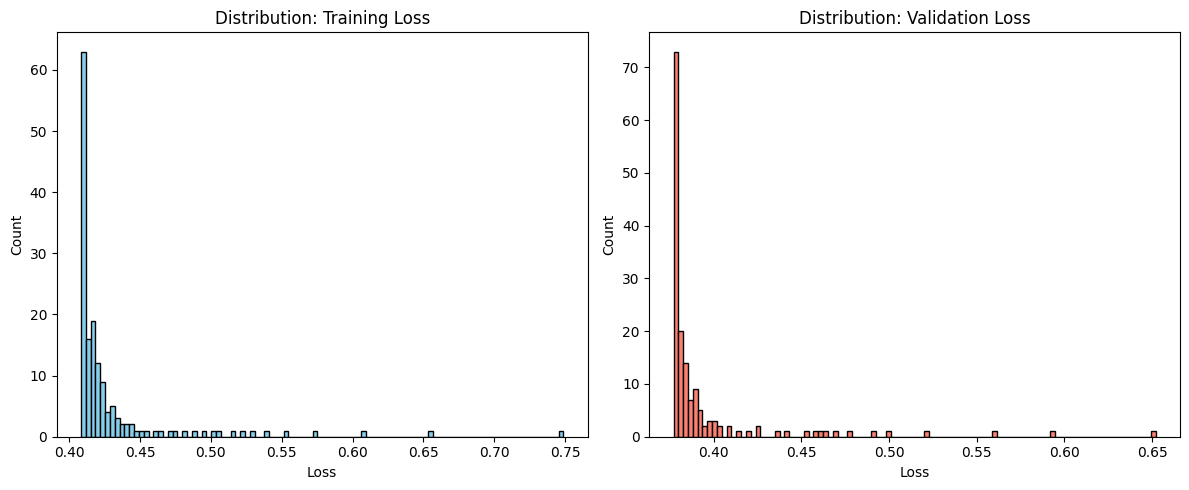

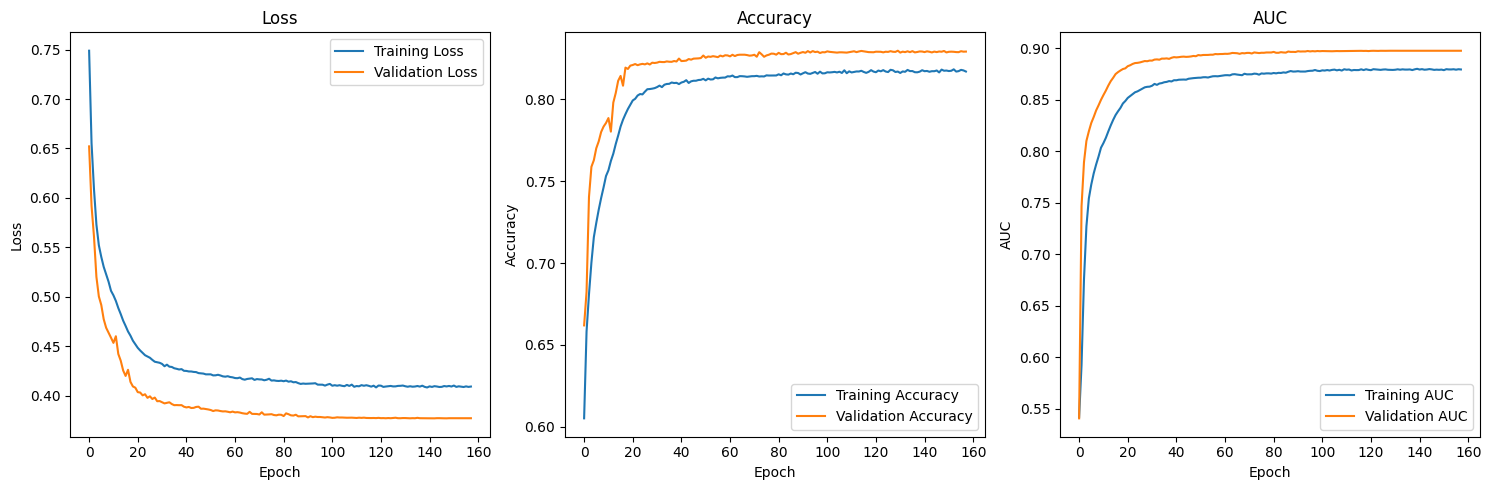

In [49]:
visualize_loss_pdf(history_cnn)
visualize_loss(history_cnn)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


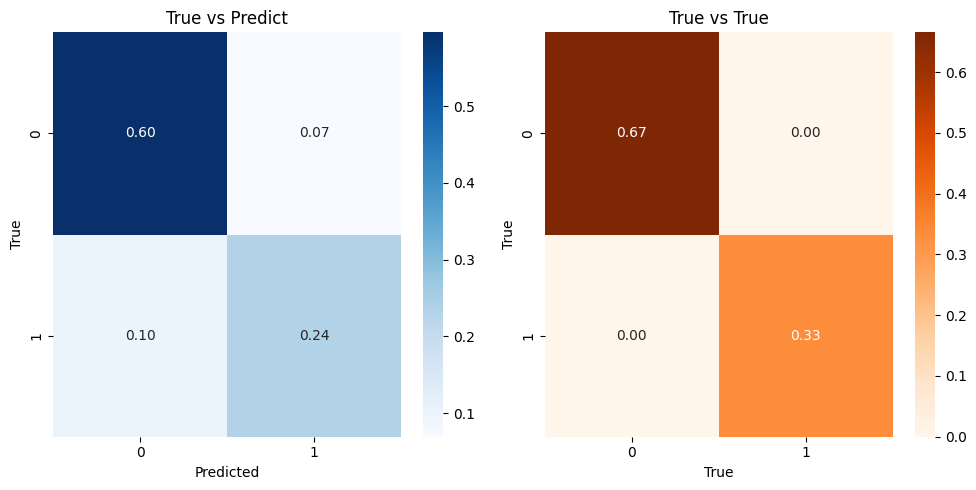

In [50]:
y_pred_cnn = cnn.predict(X_test)
ConfusionMatrix(y_test, y_pred_cnn)

## CLAM Attention Network (CLAM)

To increase the performance we can use the attention mechanism, which allows the model to focus on the most important features of the dataset.
In particular the idea is to use a Attention mechanism similar to the one used in the CLAM model, which is used for histopathological image classification.

We compute the attention score trough two dense layers, the first one with a **tanh** activation function and the second one with a **softmax** activation function, to obtain a probability distribution over the features.
$$ 
h_k = \tanh(W x_k^T + b)
$$
$$
\alpha_k = \frac{\exp(V h_k^T + c)}{\sum_{j=1}^{K} \exp(V h_j^T + c)}
$$  
where:
- $x_k$ is the feature vector of the $k$-th feature. 
- $W$ and $V$ are the weight matrices and $b$ and $c$ are the bias vectors, all of these are trainable parameters.
- $h_k$ is the hidden representation of the $k$-th feature.
- $\alpha_k$ is the attention score of the $k$-th feature.

So we obtain a matrix of attention scores, $\Alpha$, with shape (batch size, number of classes, number of features).
Then we compute the **slide representation**, $z$, as a weighted sum of the feature vectors, where the weights are given by the attention scores:
$$
z = \sum_{k=1}^{K} \alpha_k x_k = \Alpha \cdot X
$$

**Observation**: We also use **positional encoding**, to give the model information about the position of the features in the dataset.

In [ ]:
# Reshape X data for the model input (samples, 1, 41)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Reshape y data for the model target (samples,) for training and evaluation
y_train = y_train.reshape(y_train.shape[0],)
y_val = y_val.reshape(y_val.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

In [52]:

import keras
import tensorflow as tf

# --- Hyperparameters ---
embedding_dim = 64
n_patch = X.shape[1]
dropout_rate = 0.5
regularizer_rate = 1e-5
n_classes = 2  # adjust for your dataset


# --- Inputs ---
inputs = keras.layers.Input(shape=(1, n_patch))

# Positional Embedding
pos = tf.range(start=0, limit=n_patch, delta=1)
pos_embedding = keras.layers.Embedding(input_dim=n_patch, output_dim=embedding_dim)(pos)

input_embedding = keras.layers.Dense(embedding_dim)(inputs)
x = input_embedding + pos_embedding

# CLAM Attention
attn_w = keras.layers.Dense(128, activation="tanh")(x)
attn_w = keras.layers.Dense(n_classes, activation="softmax")(attn_w)  # per-class attention scores

# weighted pooling: (batch, patches, embedding_dim) × (batch, patches, classes)
attn_w_T = keras.ops.transpose(attn_w, axes=[0,2,1])   # (batch, classes, patches)
slide_repr = keras.ops.matmul(attn_w_T, x)             # (batch, classes, embedding_dim)
slide_repr = keras.layers.Flatten()(slide_repr)

ffn = keras.layers.Dense(embedding_dim * 4, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(slide_repr)
ffn = keras.layers.LeakyReLU()(ffn)
ffn = keras.layers.Dropout(dropout_rate)(ffn)
ffn = keras.layers.Dense(embedding_dim * 2, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(ffn)
ffn = keras.layers.LeakyReLU()(ffn)
ffn = keras.layers.Dropout(dropout_rate)(ffn)
ffn = keras.layers.Dense(embedding_dim, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(ffn)
ffn = keras.layers.LeakyReLU()(ffn)
ffn = keras.layers.Dropout(dropout_rate)(ffn)

outputs = keras.layers.Dense(1, activation="sigmoid")(ffn)

# --- Model ---
clam = keras.Model(inputs, outputs)
clam.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1, 41)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1, 64)     │      2,688 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 41, 64)    │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 41, 128)   │      8,320 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 41, 2)     │        258 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 2, 41)     │          0 │ dense_30[0][0]    │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matmul_1 (Matmul)   │ (None, 2, 64)     │          0 │ transpose_1[0][0… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 128)       │          0 │ matmul_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │     33,024 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 256)       │          0 │ dense_31[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256)       │          0 │ leaky_re_lu_15[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ leaky_re_lu_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 64)        │          0 │ dense_33[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ leaky_re_lu_17[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1)         │         65 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,507 (334.01 KB)

 Trainable params: 85,507 (334.01 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile
clam.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
 )

# Training
history_clam = clam.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=512,
    shuffle=True,
    callbacks=[reduce_lr, early_stopping]
)

clam.save_weights("gdrive/My Drive/HiggsBoson_Astrostatistic/weights/Attention_CLAM.weights.h5")

Epoch 1/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.6534 - auc: 0.6529 - loss: 3.5410 - val_accuracy: 0.7821 - val_auc: 0.8605 - val_loss: 0.4740 - learning_rate: 5.0000e-04
Epoch 2/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7189 - auc: 0.7682 - loss: 0.7318 - val_accuracy: 0.8093 - val_auc: 0.8780 - val_loss: 0.4414 - learning_rate: 5.0000e-04
Epoch 3/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7629 - auc: 0.8240 - loss: 0.5275 - val_accuracy: 0.8168 - val_auc: 0.8864 - val_loss: 0.4275 - learning_rate: 5.0000e-04
Epoch 4/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7890 - auc: 0.8528 - loss: 0.4663 - val_accuracy: 0.8249 - val_auc: 0.8925 - val_loss: 0.4090 - learning_rate: 5.0000e-04
Epoch 5/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8041 - auc: 0.8698 - loss: 0.4373 - val_accuracy: 0.8281 - val_auc: 0.8955 - val_loss: 0.4018 - learning_rate: 5.0000e-04
Epoch 6/300
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step 

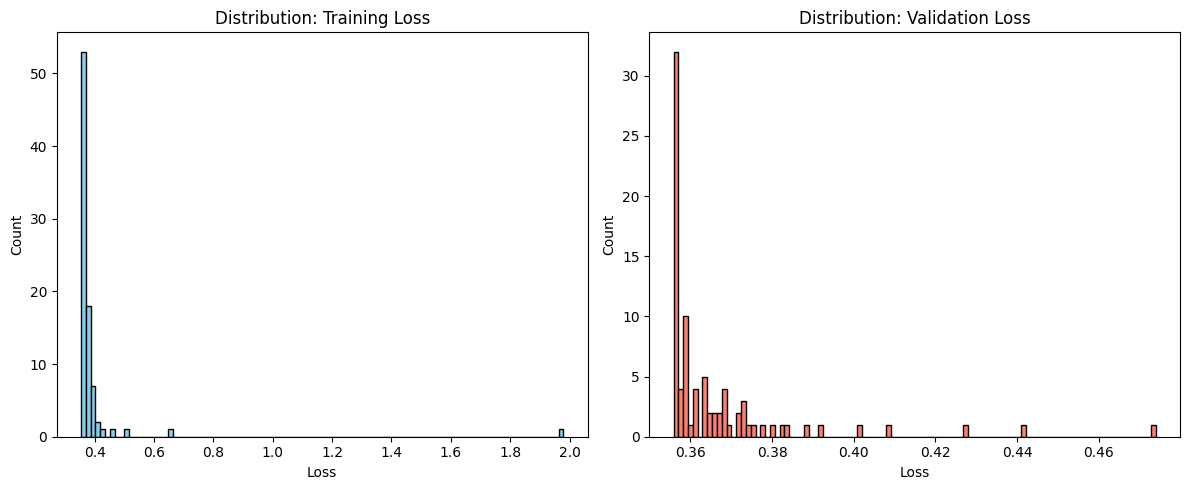

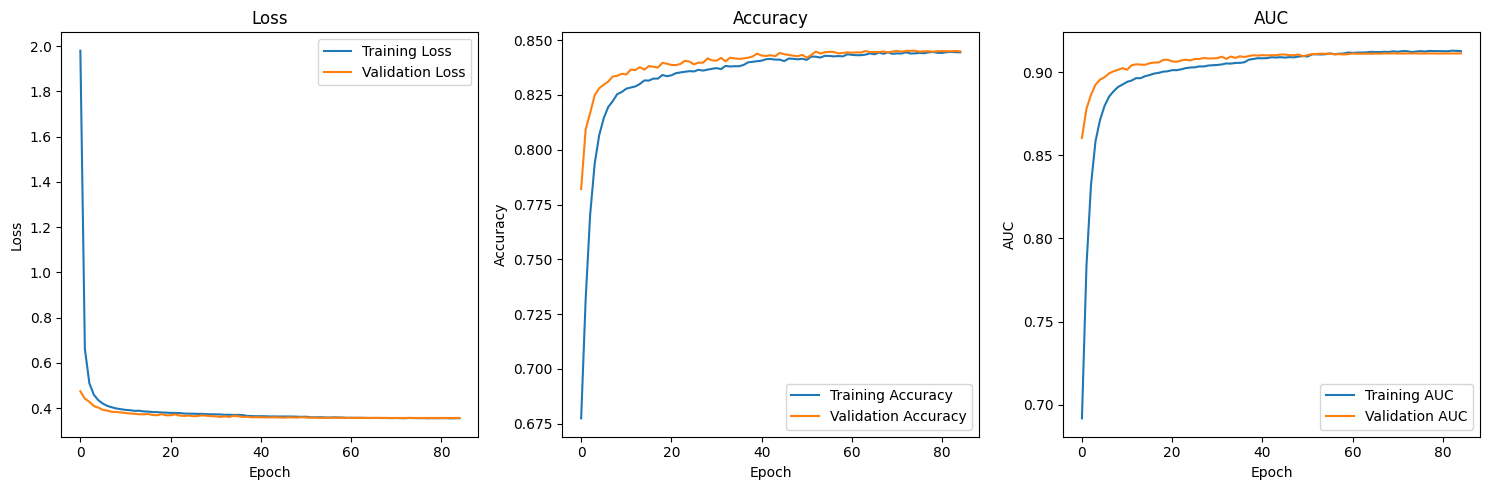

In [54]:
visualize_loss_pdf(history_clam)
visualize_loss(history_clam)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


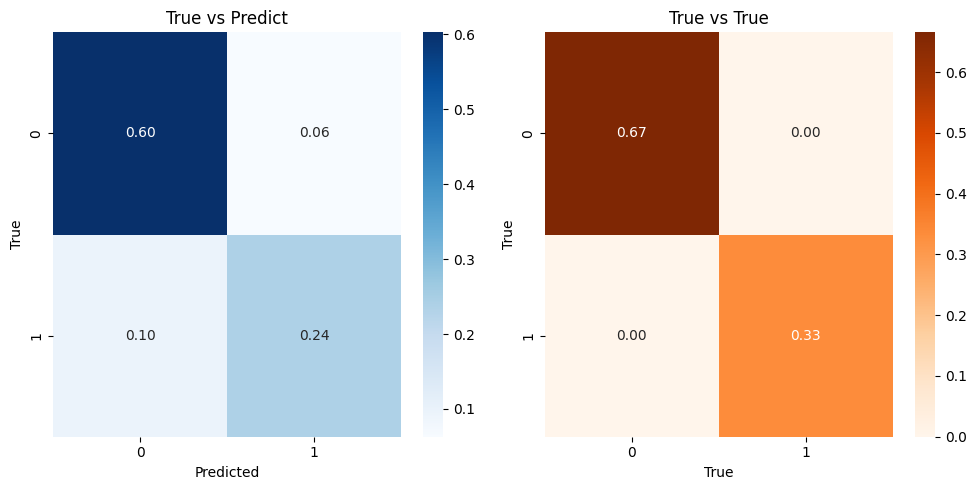

In [55]:
y_pred_clam = clam.predict(X_test)
ConfusionMatrix(y_test, y_pred_clam)

## Comparison of the models
To compare the models we use the ROC curve and the AUC score.

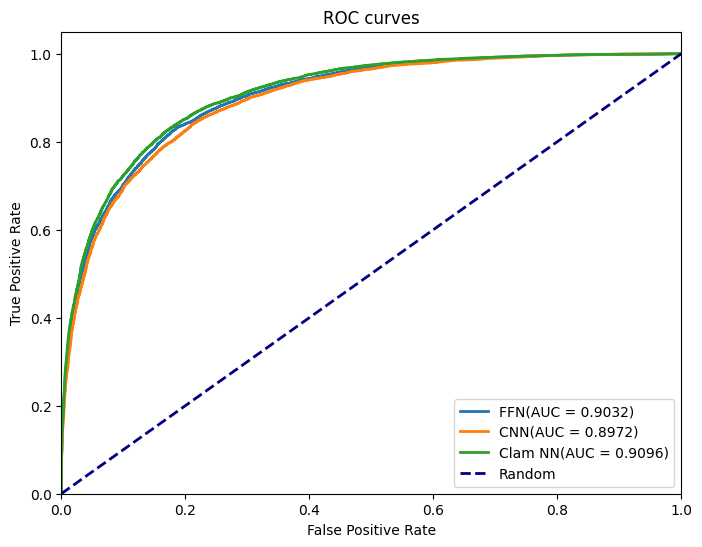

In [56]:
ROC_curves(y_test, [y_pred_ffn, y_pred_cnn, y_pred_clam], ["FFN", "CNN", "Clam NN"])

The CLAM model is the one that performs better, even if the difference with the other models is not big.

Probably the best way to improve the performance is to use a bigger dataset, with more samples, or maybe use data augmentation techniques, even if it's not so easy to do it with particle physics data.